<a href="https://colab.research.google.com/github/davdavDTB/WeightsWatchers/blob/master/weightswatchers_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WeightsWatchers SVM
by Ben Halima, Kerim; Campbell, David E.T.; Taskiran, Diyar

# Introduction
As part of the course 6,126,1.00 Machine Learning, we created a Support Vector Machine classifier for the Fashion-MNIST image dataset. To cope with the size of the dataset, we used Principal Component Analysis (PCA) as a dimensionality reduction technique. Ultimately, we achieved an accuracy score of over 90.27%.


![Bulbasaur](https://cdn.bulbagarden.net/upload/thumb/2/21/001Bulbasaur.png/240px-001Bulbasaur.png)

# Imports and seed

Our setup consists of standard python libraries. We use scikit-learn's tools for Machine Learning. We also define a seed for reproducibility.

In [1]:
#used only for data loading
import tensorflow as tf

#standard python libraries
import numpy as np
from datetime import datetime

#dimensionality reduction
from sklearn.decomposition import PCA

#classifier and evaluation
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix

#visuals and plotting
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
random_seed = 42

# The Data

## FashionMNIST dataset download and visualization

Fashion-MNIST is a dataset of 70'000 28x28 pixel grayscale images of Zalando articles. Intended to serve as a direct drop-in replacement to the MNIST dataset, it conveniently splits into 60'000/10'000 training and test images.

[More about Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)

One easy way to download our dataset is from Tenserflow, as it is directly available there.

In [3]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


Here we simply plot a few images to look at the data. We also create a dictionary that is going to allow us to link a the values of the labels to the class name all throughout the script.

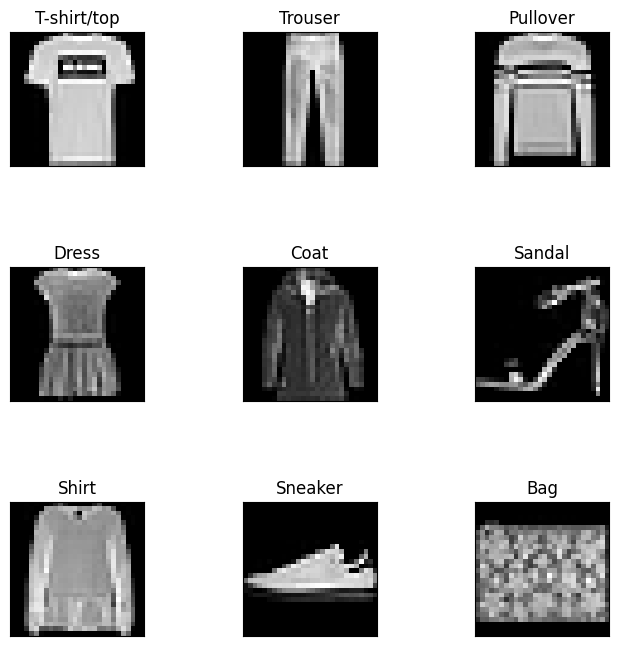

In [4]:
fashion_classes     = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'}

fig = plt.figure(figsize=(8, 8), dpi = 100)

for i in range(9):
  ax = plt.subplot(331 + i) 
  plt.subplots_adjust(wspace = .5, hspace = .75)
  plt.tick_params( axis='both', which='both', bottom=False, left = False, labelleft=False, labelbottom=False)
  # To ensure plotting different classes, we search the index based on the loop's number and use the created dictionary to name the values.
  ind = np.where(y_train == i)
  ax.set_title(fashion_classes[y_train[ind[0][0]]], fontdict = {"fontsize":12})
  plt.imshow(x_train[ind[0][0]], cmap = plt.get_cmap("gray"))



## Data preprocessing

The classifier requires that the data be 2-dimensional for fitting. Our image set, that will go through the fit() and predict() methods, is three dimensional: 28 arrays that each contain 28 pixel values of their corresponding row are kept within an array, which represents all the information in one image. This array is part of a larger array that contains all the images. Arrays (rows) within arrays (images) within one huge array. To reduce this to 2 dimensions, we flatten the images. By doing so, we simply remove one step - all the pixel values of an image make one array of 784 values (28x28), and this array is part of a bigger array which contains all images. Arrays (images) within one array.

In [0]:
#Flattening train images
x_train_flat = np.reshape(x_train, (60000, 784))

In [0]:
#Flattening test images
x_test_flat = np.reshape(x_test, (10000, 784))

# Dimensionality reduction using Principle Component Analysis
PCA is a dimensionality reduction technique that transforms the columns of a dataset into a new set features. It finds a linear projection of high dimensional data into a lower dimensional subspace such as the variance retained is maximized. PCA thus finds the directions (by using eigenvectors) that explain the maximum variability in the data. We try to find the most relevant set of variables from the dataset and linearly combine that set into a single variable. This is a Principal Component. An unfortunate cost of this dimensionality reduction process is that the non-linear information is lost. In our case, scaling the images does not seem necessary for PCA because the information contained in each image is directly comparable (each image has the same size).

To sum up, PCA essentially allows the main information contained in the original data to be represented into a fewer number of columns, which are easier to process.

The PCs are ordered in such a way that the first PC explains the most variance across the data, the second PC explains the second most variance etc..

[More about PCA](https://www.machinelearningplus.com/machine-learning/principal-components-analysis-pca-better-explained/)


In [7]:
#Principle Component Analysis
start_time = datetime.now()

n_components = 784
pca = PCA(n_components) 
pca.fit(x_train_flat)
pca_train = pca.transform(x_train_flat)
pca_test = pca.transform(x_test_flat)

end_time = datetime.now()
print('Duration: {}\n'.format(end_time - start_time))

Duration: 0:00:14.689217



In [8]:
#We examine the effects of PCA
ratios = pca.explained_variance_ratio_

print('Variance of the first ten principal components:', ratios.round(4)[:10])
print('Variance principal components 90 to 100:', ratios.round(4)[(90):100])
print('Variance of the last ten principal components', ratios.round(7)[(n_components-10):n_components])

expl_variance = 0

for i in ratios:
  expl_variance += i
print('\nTotal explained variance =', expl_variance.round(4)*100,"%")

for i in range(np.cumsum(ratios).shape[0]):
  if np.cumsum(ratios)[i] >= 1:
    num_pca = i + 1
    print("\nThe optimal number of PCAs is: {}".format(num_pca),"(the maximum) to get 100% of the variance explained.")
    break

Variance of the first ten principal components: [0.2904 0.1776 0.0602 0.0496 0.0385 0.0346 0.0234 0.0191 0.0135 0.0131]
Variance principal components 90 to 100: [0.0007 0.0007 0.0007 0.0007 0.0007 0.0007 0.0007 0.0007 0.0007 0.0007]
Variance of the last ten principal components [4.e-07 3.e-07 2.e-07 2.e-07 1.e-07 1.e-07 1.e-07 0.e+00 0.e+00 0.e+00]

Total explained variance = 100.0 %

The optimal number of PCAs is: 784 (the maximum) to get 100% of the variance explained.


Here we just show representations of the eigenvectors, so they do not make much sense...

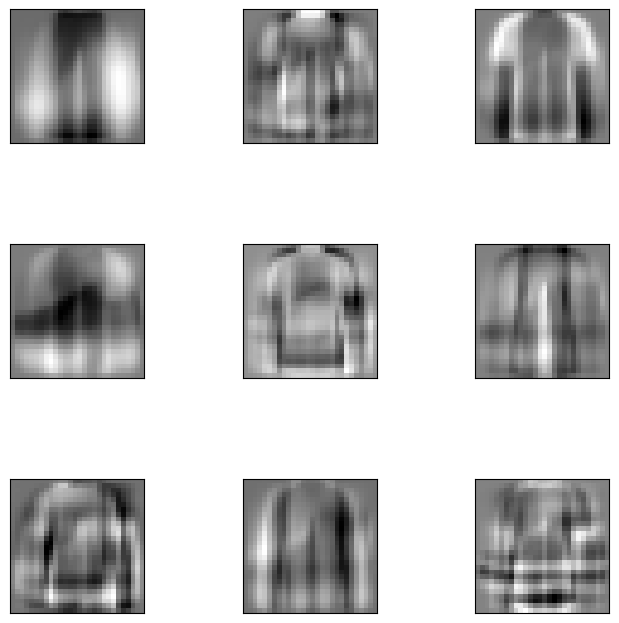

In [9]:
fig = plt.figure(figsize=(8, 8), dpi = 100)

for i in range(9):
  ax = plt.subplot(331 + i)
  plt.subplots_adjust(wspace = .5, hspace = .75)
  plt.tick_params( axis='both', which='both', bottom=False, left = False, labelleft=False, labelbottom=False)
  ind = np.where(y_train == i)
  ax.imshow(pca.components_[ind[0][0]].reshape(28,28),cmap="gray")

Here we reconstructed the images based on our eigenvectors - we see that although the images are not exactly as they are in the original dataset (due to PCA's dimensionality reduction), the reconstruction is pretty accurate and we can clearly make out what the different images are.

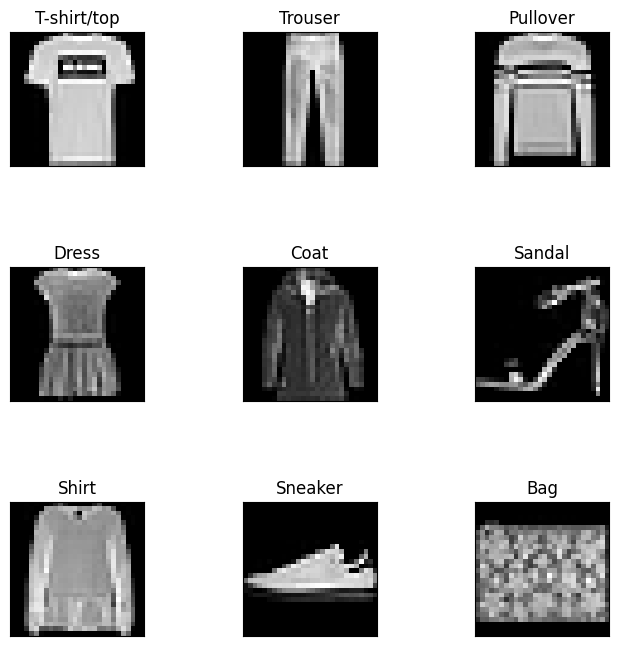

In [10]:
projected = pca.inverse_transform(pca_train)

fig = plt.figure(figsize=(8, 8), dpi = 100)

for i in range(9):
  ax = plt.subplot(331 + i)
  plt.subplots_adjust(wspace = .5, hspace = .75)
  plt.tick_params( axis='both', which='both', bottom=False, left = False, labelleft=False, labelbottom=False)
  ind = np.where(y_train == i)
  ax.set_title(fashion_classes[y_train[ind[0][0]]], fontdict = {"fontsize":12})
  ax.imshow(projected[ind[0][0]].reshape(28,28),cmap="gray")

As the following graph shows, the percentage of image variance that PCA finds increases monotonically and converges to 100%. We see that the first ~250 principal components incrementally add noticeable inputs. If we set the number of components to the maximum (i.e. 784, or 28x28), the additional variance detected by components [500:784] is represented in a quasi-horizontal line. 

Interestingly, when n_components = 784 (PCs), the accuracy of our SVM is always 90.27% (we set a random seed). When n_components is lower, for instance 470, 99% of the variance is explained and the accuracy varies between 90.12% and 90.42% (gets 90.27% on average). One must keep in mind that PCA actually does not help get better accuracy, but "simplifies" the data while keeping its important information to make SVM classification feasable.

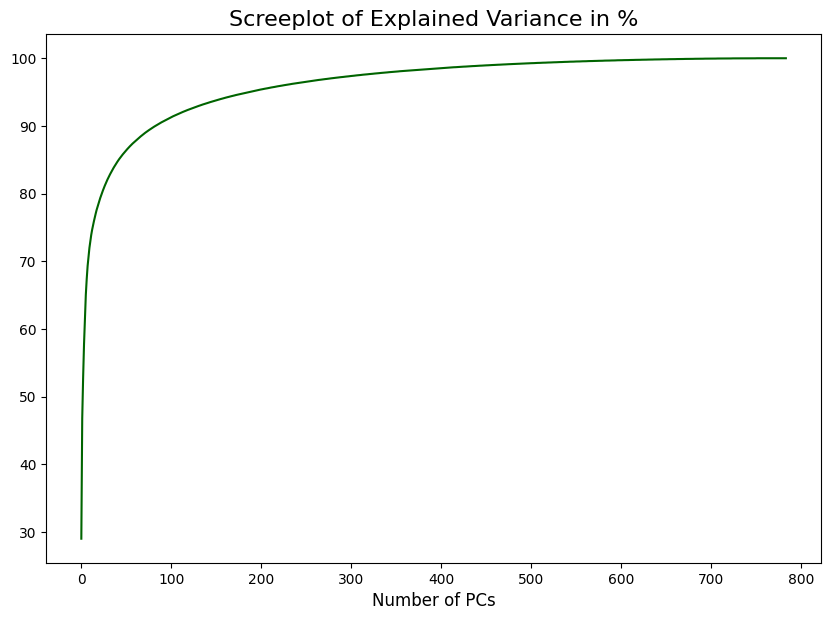

In [11]:
variance_exp_cumsum = (pca.explained_variance_ratio_.cumsum().round(4)*100)
fig, axes = plt.subplots(1,1,figsize=(10,7), dpi=100)
plt.plot(variance_exp_cumsum, color='darkgreen')
plt.title('Screeplot of Explained Variance in %', fontsize=16, color = 'black')
plt.xlabel('Number of PCs', fontsize=12, color = 'black')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.show()

# Support Vector Machine model training and classification

Through multiple GridSearch attempts and trial and error, we found that the following parameters work best for our classifier.

In [12]:
#Defining classifier parameters and fitting train data
start_time = datetime.now()

clf = svm.SVC(C = 10, kernel = 'rbf', random_state=random_seed)
clf.fit(pca_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:12:38.147535


Predictions on training and test data:

In [13]:
#Predictions on train data
#We would not normally include this but it was required for the Coding Challenge
start_time = datetime.now()
"""
predicted_train = clf.predict(pca_train)
"""
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.000123


In [14]:
#Predictions on test data
start_time = datetime.now()

predicted = clf.predict(pca_test)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:26.020956


# Evaluation

We now examine the results of our classifier with metrics and a confusion matrix. For fun, we also show accuracy per class, make a few random predictions and show images that were incorrectly classified.

In [15]:
#Result count and accuracy
correct = 0
false = 0

for i in range(0, len(y_test)):
    if predicted[i] == y_test[i]:
        correct += 1
    else:
        false += 1

print("Number of correct predictions: ", correct, "\n")
print("Number of false predictions: ", false, "\n")

accuracy = correct/len(y_test)
print("Accuracy =", accuracy*100, ("%"))

Number of correct predictions:  9027 

Number of false predictions:  973 

Accuracy = 90.27 %


In [17]:
#Metrics
acc = metrics.accuracy_score(y_test, predicted)
#acc_train = metrics.accuracy_score(y_train, predicted_train)
prec = metrics.precision_score(y_test, predicted, average='weighted')
rec = metrics.recall_score(y_test, predicted, average='weighted')
f1 = metrics.f1_score(y_test, predicted, average='weighted')

print("Accuracy (Test Set) =", acc*100, "%")
print("Accuracy (Train Set) =", acc_train.round(4)*100, "%")
print("Precision =", prec.round(4))
print("Recall =", rec.round(4))
print("F1 Score =", f1.round(4), "\n")

print("classification report: \n\n", classification_report((y_test), predicted, 
                                                           target_names=list(fashion_classes.values()), digits=4))

Accuracy (Test Set) = 90.27 %


NameError: ignored

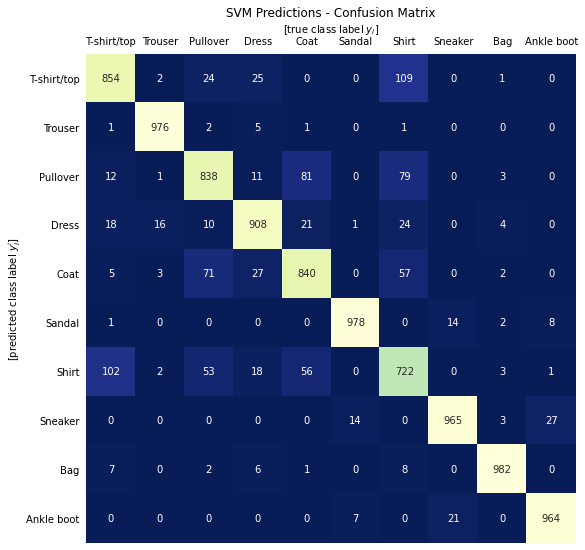

In [18]:
#Confusion matrix
mat = confusion_matrix(y_test, predicted)

# init the plot
plt.figure(figsize=(9, 9))

# plot confusion matrix heatmap
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')
ax.xaxis.set_label_position("top")
# add plot title
plt.title('SVM Predictions - Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Accuracy per class')

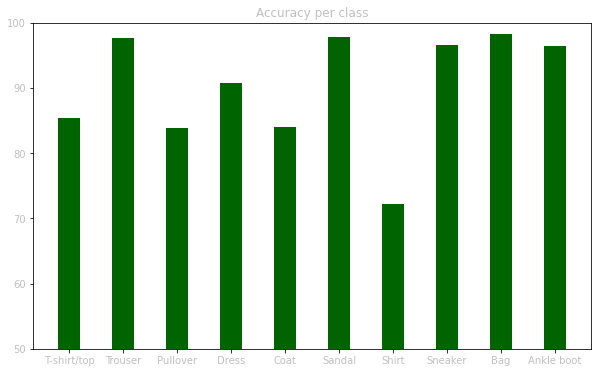

In [19]:
#Plotting the accuracy of each class
acc_score_per_class = []

for i in range(10):
  c = (mat[i][i]) / 10
  acc_score_per_class.append(c)

plt.figure(figsize=(10, 6))

width = 0.4
x = np.arange(10)
plt.bar(x, acc_score_per_class, width, align='center', color = 'darkgreen')
# Assuming dark mode in colab, comment out to make legible in jupyter
plt.xticks(x, (value for key, value in fashion_classes.items()), color = 'silver')
plt.ylim(50, 100)
plt.yticks(color = 'silver')
plt.title('Accuracy per class', color = 'silver')

As we can see from the confusion matrix and the accuracy per class, the model struggles (unsurprisingly) to distinguish Shirts from T-shirts/tops and the other tops (Coats, Pullovers)

In [20]:
#Showing a few random predictions
print("Random predictions: \n")
pred = clf.predict(pca_test[0:50])

randnums = np.random.randint(0,50,5)
for i in range(0, len(randnums)):
  print("Random prediction #{}:\nPredicted clothing = {}\nTrue clothing = {}\n".format(i + 1, fashion_classes[int(pred[randnums[i]])], fashion_classes[int(y_test[randnums[i]])])) 

Random predictions: 

Random prediction #1:
Predicted clothing = Dress
True clothing = Dress

Random prediction #2:
Predicted clothing = Dress
True clothing = Dress

Random prediction #3:
Predicted clothing = Trouser
True clothing = Trouser

Random prediction #4:
Predicted clothing = Shirt
True clothing = Shirt

Random prediction #5:
Predicted clothing = Dress
True clothing = Dress



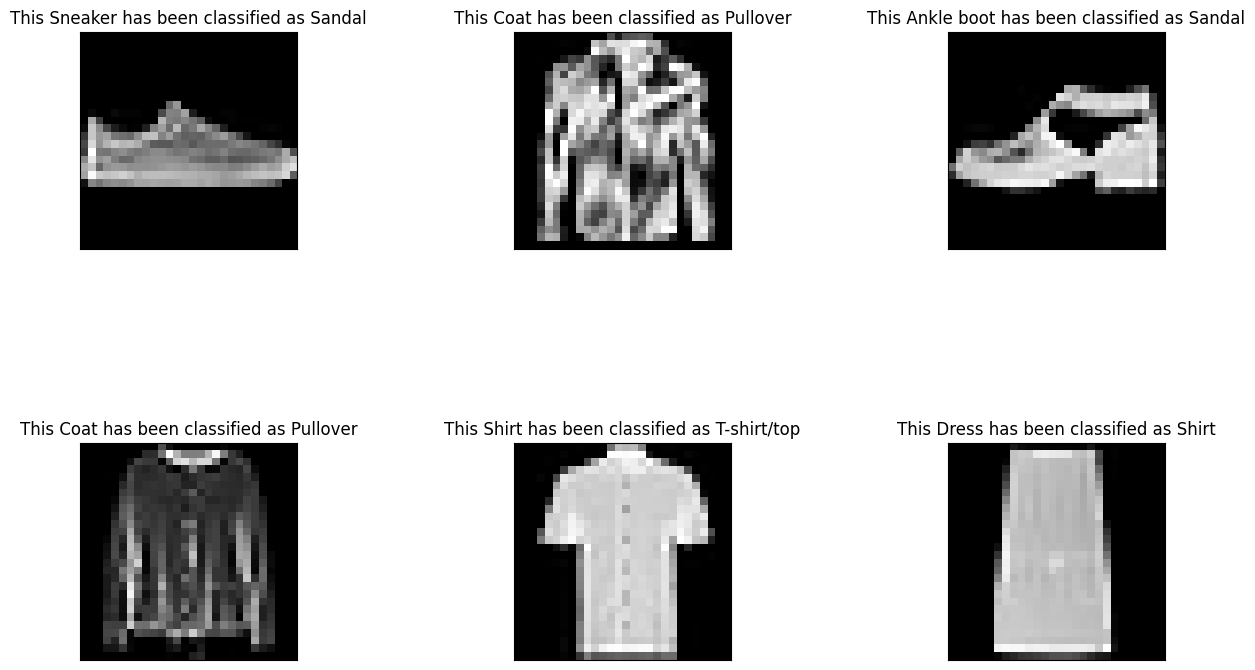

In [21]:
#Plotting erroneous predictions
counter = 0
fig = plt.figure(figsize=(14, 14), dpi = 100)

for inp, prediction, label in zip(x_test, predicted, y_test):
  if prediction != label:
    counter += 1
    ax = plt.subplot(330 + counter)
    plt.subplots_adjust(wspace = 1, hspace = .75)
    plt.tick_params( axis='both', which='both', bottom=False, left = False, labelleft=False, labelbottom=False)
    ax.set_title("This {} has been classified as {}".format(fashion_classes[label], fashion_classes[prediction]), fontdict = {"fontsize":12})
    plt.imshow(inp, cmap = plt.get_cmap("gray"))
    if counter == 6:
      break

# Concluding remarks

After having spent quite some time looking for ways to optimize our classifier through feature description, PCA implementation and SVM hyperparameters, we are happy to have reached our current model.

Our Support Vector Machine classifier manages to classify the FashionMNIST dataset with a reliable accuracy of above 90%. It does not use any feature extraction algorithm and only uses PCA's dimensionality reduction benefits. Therefore, it saves computation time (script takes about 16 minutes on colab if one does not try to predict the training set).

Although it may be easier to implement and run, the accuracy of SVM cannot match that of modern Neural Networks (c.f. our WideResidualNetwork (WRN)). Its main advantages are its simpler programming process and execution speed.

More effort could however be given to analyze the effects of different feature extraction algorithms on accuracy. We have only explored HoG and SIFT (both with and without PCA), which did not improve accuracy and increased computation time.

*We would like to thank Marco Schreyer for his valuable inputs and support throughout the challenge. Further thanks go to the stackoverflow community, the Google Colab infrastructure and to Bulbasaur.*